# A Time Series Regression Analysis: Building Regresssion Models to Predict The Demands of Product

### **Problem Statement**

Corporation Favorita, a prominent a large Ecuadorian-based grocery retailer, aims to ensure that they always have the right quantity of products in stock. To acheive this as a data scientist in Corporation Favorita, we will build a series of machine learning models to forecast the demand of products in various locations.

### **Objective**
The primary objective of this project is to develop a robust time series regression model that more accurately predicts the unit sales for thousands of items. Important for Corporation Favorita’s various products across its different store locations. The model should account for historical sales data, promotional activities, holidays, and other relevant factors that influence sales.

### **Expected Impact**
By developing an accurate sales forecasting model, Corporation Favorita can better manage its inventory, reduce stockouts and overstock situations, and enhance overall customer satisfaction. This project will contribute to the company’s strategic planning and operational efficiency, ultimately driving higher profitability and growth.

### BUSINESS UNDERSTANDING

#### **Project Goal**: The aim of the project is to build a classification model that will forecast the demands of products in various locations.





**Null Hypothesis (H₀):** There is no changes in sales before and after promotion.

**Alternative Hypothesis (H₁):** There is a change in sales before and after promotion..

### **Analytical Questions**

1. Is the train dataset complete (has all the required dates)?
2. Which dates have the lowest and highest sales for each year (excluding days the store was closed)?
3. Compare the sales for each month across the years and determine which month of which year had the highest sales.
4. Did the earthquake impact sales?
5. Are certain stores or groups of stores selling more products? (Cluster, city, state, type)
6. Are sales affected by promotions, oil prices and holidays?
7. What analysis can we get from the date and its extractable features?
8. Which product family and stores did the promotions affect.
9. What is the difference between RMSLE, RMSE, MSE (or why is the MAE greater than all of them?)
10. Does the payment of wages in the public sector on the 15th and last days of the month influence the store

In [132]:

# Data Manipulation and Connection
import numpy as np
import pandas as pd
import pyodbc
from dotenv import dotenv_values

import statsmodels.api as sm
from statsmodels.formula.api import ols
from scipy.stats import ttest_ind, boxcox, shapiro, mannwhitneyu

# Visualizations
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_log_error, make_scorer
import os
import pickle
import zipfile

# Library for hyperparameter tuning
from sklearn.model_selection import RandomizedSearchCV


import warnings
warnings.filterwarnings('ignore')

In [3]:
# Load environment variables from .env file into a dictionary
environment_variables = dotenv_values('.env')


# Get the values for the credentials you set in the '.env' file
server = environment_variables.get("SERVER")
database = environment_variables.get("DATABASE")
username = environment_variables.get("USERNAME")
password = environment_variables.get("PASSWORD")


In [4]:
# use f sring to connect to the database.
connection_string=f"DRIVER={{SQL Server}};SERVER={server};DATABASE={database};UID={username};PWD={password}"

In [5]:
# Use the connect method of the pyodbc library and pass in the connection string.
connection=pyodbc.connect(connection_string)

## Data Understanding
The data for this projects has been divided into 3. 

From an SQL database management system, three tables are contained.
Within the OneDrive, two files which are just for testing and not training.
Finally, contained in a GitHub repository are additional files.


In [6]:
# SQL Query to get data from the database.
query="Select * from dbo.oil"
oil = pd.read_sql(query,connection)

# Display the first 5 rows of the data

oil.head(5)

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.139999
2,2013-01-03,92.970001
3,2013-01-04,93.120003
4,2013-01-07,93.199997


In [7]:
query="Select * from dbo.holidays_events"
holidays_events = pd.read_sql(query,connection)

# Display the first 5 rows of the data

holidays_events.head(5)

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


In [8]:
query="Select * from dbo.stores"
stores = pd.read_sql(query,connection)

# Display the first 5 rows of the data

stores.head(5)

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


In [9]:
train = pd.read_csv(r"C:\Users\user\Documents\New folder\LP.3\store-sales-forecasting\train.csv")
# Display the first 5 rows of the data
train.head(5) 


,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


In [10]:
transactions = pd.read_csv(r"C:\Users\user\Documents\New folder\LP.3\store-sales-forecasting\transactions.csv")

# Display the first 5 rows of the data

transactions.head(5)

,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922


In [11]:
# Create a dictionary of the datasets
data = {'holiday': holidays_events, 'stores': stores, 'oil': oil, 'transactions': transactions, 'train': train}



In [12]:
# Check the datatypes and presence of missing values in each of the datasets
# Using '\033[1mtext\033[0m' to make text bold
for df_name, dataset in data.items():
    print(f'\033[1mFor {df_name} dataset\033[0m:')
    dataset.info()
    print('_'*45)
    print('\n')


For holiday dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350 entries, 0 to 349
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   date         350 non-null    object
 1   type         350 non-null    object
 2   locale       350 non-null    object
 3   locale_name  350 non-null    object
 4   description  350 non-null    object
 5   transferred  350 non-null    bool  
dtypes: bool(1), object(5)
memory usage: 14.1+ KB
_____________________________________________


For stores dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54 entries, 0 to 53
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   store_nbr  54 non-null     int64 
 1   city       54 non-null     object
 2   state      54 non-null     object
 3   type       54 non-null     object
 4   cluster    54 non-null     int64 
dtypes: int64(2), object(3)
memory usage: 2.2+ KB
____

In [13]:
# Check the shape, and the presence of missing values and duplicates in each of the datasets
# Use '\033[1mtext\033[0m' to make text bold
for df_name, dataset in data.items():
    print(f'\033[1mFor {df_name} dataset\033[0m')
    print(f'Shape: {dataset.shape}')
    print(f'Missing values = {dataset.isna().sum().sum()}')
    print(f'Duplicates = {dataset.duplicated().sum()}')
    print('_'*30)
    print('\n')


For holiday dataset
Shape: (350, 6)
Missing values = 0
Duplicates = 0
______________________________


For stores dataset
Shape: (54, 5)
Missing values = 0
Duplicates = 0
______________________________


For oil dataset
Shape: (1218, 2)
Missing values = 43
Duplicates = 0
______________________________


For transactions dataset
Shape: (83488, 3)
Missing values = 0
Duplicates = 0
______________________________


For train dataset
Shape: (3000888, 6)
Missing values = 0
Duplicates = 0
______________________________




### Key Observations
- The only column with missing values is "dcoilwtico" from the oil dataset, which has 43 missing values 
 - All the date columns in the dataset are all in obect format
 - There are no duplicates in the dataset.
 - There is no column to identify the days in which there were holidays and days in which there were no holidays.

#### **Merge the datasets based on common columns**

In [14]:
# Merge transactions dataset to train on 'date' and 'store_nbr' columns
df1 = pd.merge(train, transactions, on=['date', 'store_nbr'], how='left')

# Merge holiday dataset to df1 on 'date' column
df2 = pd.merge(df1, holidays_events, on='date', how='left')

# Merge oil dataset to df2 on 'date' column
df3 = pd.merge(df2, oil, on='date', how='left')
df3

# Merge store dataset to df3 on 'store_nbr' column
df4 = pd.merge(df3, stores, on='store_nbr', how='left')

df4.head()

,id,date,store_nbr,family,sales,onpromotion,transactions,type_x,locale,locale_name,description,transferred,dcoilwtico,city,state,type_y,cluster
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,NaN,Holiday,National,Ecuador,Primer dia del ano,False,NaN,Quito,Pichincha,D,13
1,1,2013-01-01,1,BABY CARE,0.0,0,NaN,Holiday,National,Ecuador,Primer dia del ano,False,NaN,Quito,Pichincha,D,13
2,2,2013-01-01,1,BEAUTY,0.0,0,NaN,Holiday,National,Ecuador,Primer dia del ano,False,NaN,Quito,Pichincha,D,13
3,3,2013-01-01,1,BEVERAGES,0.0,0,NaN,Holiday,National,Ecuador,Primer dia del ano,False,NaN,Quito,Pichincha,D,13
4,4,2013-01-01,1,BOOKS,0.0,0,NaN,Holiday,National,Ecuador,Primer dia del ano,False,NaN,Quito,Pichincha,D,13


#### **Exploratory Analysis**

In [15]:
# Check for missing values after merging the datasets

df4.isnull().sum()

id                    0
date                  0
store_nbr             0
family                0
sales                 0
onpromotion           0
transactions     249117
type_x          2551824
locale          2551824
locale_name     2551824
description     2551824
transferred     2551824
dcoilwtico       955152
city                  0
state                 0
type_y                0
cluster               0
dtype: int64

In [16]:
# Check for duplicates after merging the datasets

df4.duplicated().sum()

0

In [17]:
# Drop the 'id' column as it is unnecessary for the analysis.

df4.drop(columns=['id'], inplace=True)

In [18]:
# Check the the columns of the dataset and there data types.
df4.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3054348 entries, 0 to 3054347
Data columns (total 16 columns):
 #   Column        Dtype  
---  ------        -----  
 0   date          object 
 1   store_nbr     int64  
 2   family        object 
 3   sales         float64
 4   onpromotion   int64  
 5   transactions  float64
 6   type_x        object 
 7   locale        object 
 8   locale_name   object 
 9   description   object 
 10  transferred   object 
 11  dcoilwtico    float64
 12  city          object 
 13  state         object 
 14  type_y        object 
 15  cluster       int64  
dtypes: float64(3), int64(3), object(10)
memory usage: 372.8+ MB


In [19]:
# Check the features of 'type_x' column to what it contains.

df4['type_x'].unique()

array(['Holiday', nan, 'Work Day', 'Additional', 'Event', 'Transfer',
       'Bridge'], dtype=object)

The column contains holiday type and will be renamed to holiday_type.

In [20]:
# Check the features of 'type_y' column to what it contains.

df4['type_y'].unique()

array(['D', 'C', 'B', 'E', 'A'], dtype=object)

This column contains store type and will be renamed to store_type.

In [21]:
# Rename 'type_x', 'dcoilwtico' and type_y' to 'holiday_type', 'oil_price' and 'store_type' respectively

df4.rename(columns={'type_x': 'holiday_type', 'dcoilwtico': 'oil_price', 'type_y':'store_type'}, inplace=True)

df4 

,date,store_nbr,family,sales,onpromotion,transactions,holiday_type,locale,locale_name,description,transferred,oil_price,city,state,store_type,cluster
0,2013-01-01,1,AUTOMOTIVE,0.000,0,NaN,Holiday,National,Ecuador,Primer dia del ano,False,NaN,Quito,Pichincha,D,13
1,2013-01-01,1,BABY CARE,0.000,0,NaN,Holiday,National,Ecuador,Primer dia del ano,False,NaN,Quito,Pichincha,D,13
2,2013-01-01,1,BEAUTY,0.000,0,NaN,Holiday,National,Ecuador,Primer dia del ano,False,NaN,Quito,Pichincha,D,13
3,2013-01-01,1,BEVERAGES,0.000,0,NaN,Holiday,National,Ecuador,Primer dia del ano,False,NaN,Quito,Pichincha,D,13
4,2013-01-01,1,BOOKS,0.000,0,NaN,Holiday,National,Ecuador,Primer dia del ano,False,NaN,Quito,Pichincha,D,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3054343,2017-08-15,9,POULTRY,438.133,0,2155.0,Holiday,Local,Riobamba,Fundacion de Riobamba,False,47.57,Quito,Pichincha,B,6
3054344,2017-08-15,9,PREPARED FOODS,154.553,1,2155.0,Holiday,Local,Riobamba,Fundacion de Riobamba,False,47.57,Quito,Pichincha,B,6
3054345,2017-08-15,9,PRODUCE,2419.729,148,2155.0,Holiday,Local,Riobamba,Fundacion de Riobamba,False,47.57,Quito,Pichincha,B,6
3054346,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,8,2155.0,Holiday,Local,Riobamba,Fundacion de Riobamba,False,47.57,Quito,Pichincha,B,6


In [22]:
# check for missing values in each column.

df4.isnull().sum()

date                  0
store_nbr             0
family                0
sales                 0
onpromotion           0
transactions     249117
holiday_type    2551824
locale          2551824
locale_name     2551824
description     2551824
transferred     2551824
oil_price        955152
city                  0
state                 0
store_type            0
cluster               0
dtype: int64

In [23]:
# Filling the transactions column.

df4['transactions'].fillna(0, inplace=True)


In [24]:
# Fill the missing values in holiday_type, locale, locale_name, description and transferred 
# columns with 'No holiday' because these columns are from the holiday dataset, and they 
# represent the days where there were no holidays.

columns_to_fill = ['holiday_type', 'locale', 'locale_name', 'description', 'transferred']
for column in columns_to_fill:
        df4[column].fillna('No holiday', inplace=True)

In [25]:
# Confirm that there are no more missing values again in these columns.
df4.isna().sum()

date                 0
store_nbr            0
family               0
sales                0
onpromotion          0
transactions         0
holiday_type         0
locale               0
locale_name          0
description          0
transferred          0
oil_price       955152
city                 0
state                0
store_type           0
cluster              0
dtype: int64

<Axes: >

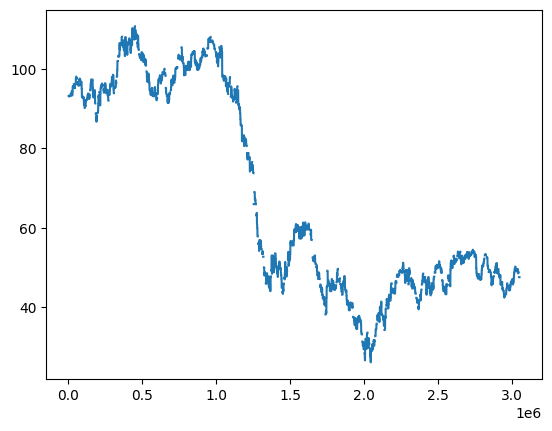

In [26]:
# check the oil_price column to see the best way to fill it missing values.

df4['oil_price'].plot()

The plot shows breakages indicating missing data points. Backward fill (bfill) can fill missing values by replacing them with the next known value in the time series. This approach is useful if you assume that the subsequent data points represent the missing values accurately.

In [27]:
# Fill the missing values in the 'oil_price' column using backward fill.

df4['oil_price'].fillna(method='bfill', inplace=True)

In [28]:
# Create the 'holiday_status' column

# Function to map holiday type to holiday status
def map_holiday_status(holiday_type):
    if holiday_type in ['No holiday', 'Work Day']:
        return 'No holiday'
    else:
        return 'Holiday'

# Add the 'holiday_status' column using the 'holiday_type' column
df4['holiday_status'] = df4['holiday_type'].apply(map_holiday_status)
df4.head()

,date,store_nbr,family,sales,onpromotion,transactions,holiday_type,locale,locale_name,description,transferred,oil_price,city,state,store_type,cluster,holiday_status
0,2013-01-01,1,AUTOMOTIVE,0.0,0,0.0,Holiday,National,Ecuador,Primer dia del ano,False,93.139999,Quito,Pichincha,D,13,Holiday
1,2013-01-01,1,BABY CARE,0.0,0,0.0,Holiday,National,Ecuador,Primer dia del ano,False,93.139999,Quito,Pichincha,D,13,Holiday
2,2013-01-01,1,BEAUTY,0.0,0,0.0,Holiday,National,Ecuador,Primer dia del ano,False,93.139999,Quito,Pichincha,D,13,Holiday
3,2013-01-01,1,BEVERAGES,0.0,0,0.0,Holiday,National,Ecuador,Primer dia del ano,False,93.139999,Quito,Pichincha,D,13,Holiday
4,2013-01-01,1,BOOKS,0.0,0,0.0,Holiday,National,Ecuador,Primer dia del ano,False,93.139999,Quito,Pichincha,D,13,Holiday


In [29]:
# Change the data type of the date column to datetime.

df4['date'] = pd.to_datetime(df4['date'])

# Confirm the data type of the date column.

df4['date'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 3054348 entries, 0 to 3054347
Series name: date
Non-Null Count    Dtype         
--------------    -----         
3054348 non-null  datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 23.3 MB


Because we are doing time series analysis it will be necessary to set date column as index column.

In [30]:
# Set date column as index column.

df4.set_index('date', inplace=True)

In [31]:
# Create time series features based on time series index.

def create_feature(df4):
    df4['weekday'] = df4.index.weekday
    df4['month'] = df4.index.month
    df4['quarter'] = df4.index.quarter 
    df4['year'] = df4.index.year
    return df4

In [32]:
# Run the feature creation on the dataset.
df4 = create_feature(df4)

# Check the feature creation.
create_feature(df4).head()


,store_nbr,family,sales,onpromotion,transactions,holiday_type,locale,locale_name,description,transferred,oil_price,city,state,store_type,cluster,holiday_status,weekday,month,quarter,year
date,,,,,,,,,,,,,,,,,,,,
2013-01-01,1,AUTOMOTIVE,0.0,0,0.0,Holiday,National,Ecuador,Primer dia del ano,False,93.139999,Quito,Pichincha,D,13,Holiday,1,1,1,2013
2013-01-01,1,BABY CARE,0.0,0,0.0,Holiday,National,Ecuador,Primer dia del ano,False,93.139999,Quito,Pichincha,D,13,Holiday,1,1,1,2013
2013-01-01,1,BEAUTY,0.0,0,0.0,Holiday,National,Ecuador,Primer dia del ano,False,93.139999,Quito,Pichincha,D,13,Holiday,1,1,1,2013
2013-01-01,1,BEVERAGES,0.0,0,0.0,Holiday,National,Ecuador,Primer dia del ano,False,93.139999,Quito,Pichincha,D,13,Holiday,1,1,1,2013
2013-01-01,1,BOOKS,0.0,0,0.0,Holiday,National,Ecuador,Primer dia del ano,False,93.139999,Quito,Pichincha,D,13,Holiday,1,1,1,2013


In [33]:
df4.describe().T

,count,mean,std,min,25%,50%,75%,max
store_nbr,3054348.0,27.500000,15.585787,1.000000,14.000000,27.500000,41.000000,54.000000
sales,3054348.0,359.020892,1107.285897,0.000000,0.000000,11.000000,196.011000,124717.000000
onpromotion,3054348.0,2.617480,12.254939,0.000000,0.000000,0.000000,0.000000,741.000000
transactions,3054348.0,1558.655862,1036.467605,0.000000,931.000000,1332.000000,1980.000000,8359.000000
oil_price,3054348.0,67.789300,25.702576,26.190001,46.279999,53.189999,95.800003,110.620003
cluster,3054348.0,8.481481,4.649735,1.000000,4.000000,8.500000,13.000000,17.000000
weekday,3054348.0,3.008168,2.001442,0.000000,1.000000,3.000000,5.000000,6.000000
month,3054348.0,6.222870,3.374251,1.000000,3.000000,6.000000,9.000000,12.000000
quarter,3054348.0,2.413652,1.095690,1.000000,1.000000,2.000000,3.000000,4.000000
year,3054348.0,2014.842474,1.345607,2013.000000,2014.000000,2015.000000,2016.000000,2017.000000


- Sales have a wide range and high standard deviation, indicating significant variability in sales amounts.
- Onpromotion values are generally low, with most observations being zero, suggesting promotions might be infrequent or not widely utilized.
- Transactions also show high variability, with a mean of 1558.66 and a maximum of 8359.
- Oil prices range from 26.19 to 110.62, with a mean of 67.79, indicating fluctuations in the oil market during the observed period.

## Univariate, Bivariate and Multivariate Analysis

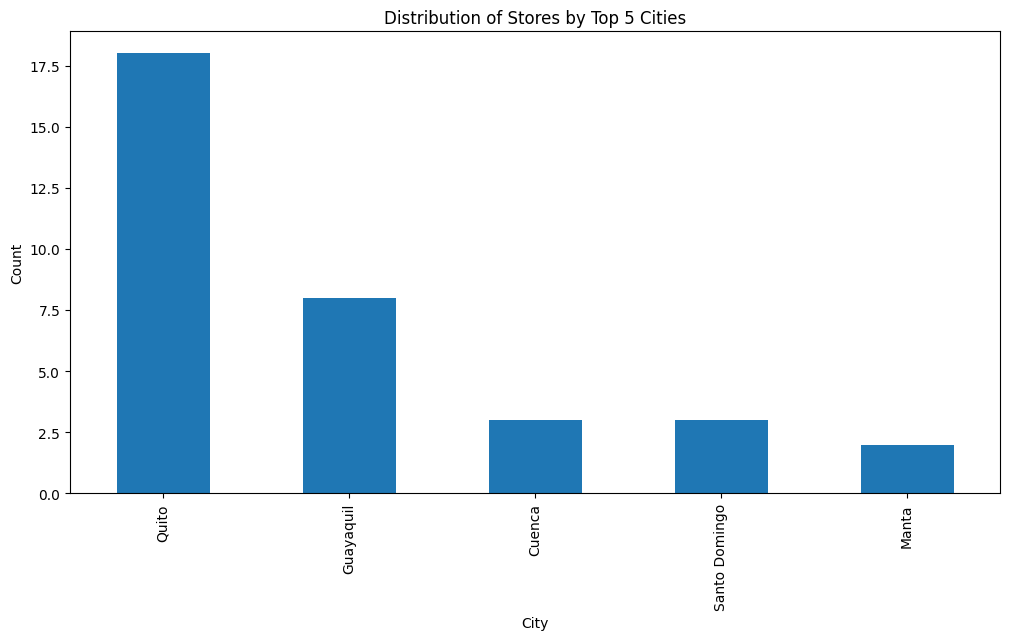

In [34]:
# Plotting the distribution of stores by top 5 cities
plt.figure(figsize=(12, 6))
stores['city'].value_counts().head(5).plot(kind='bar')
plt.xlabel('City')
plt.ylabel('Count')
plt.title('Distribution of Stores by Top 5 Cities')
plt.show()


<function matplotlib.pyplot.show(close=None, block=None)>

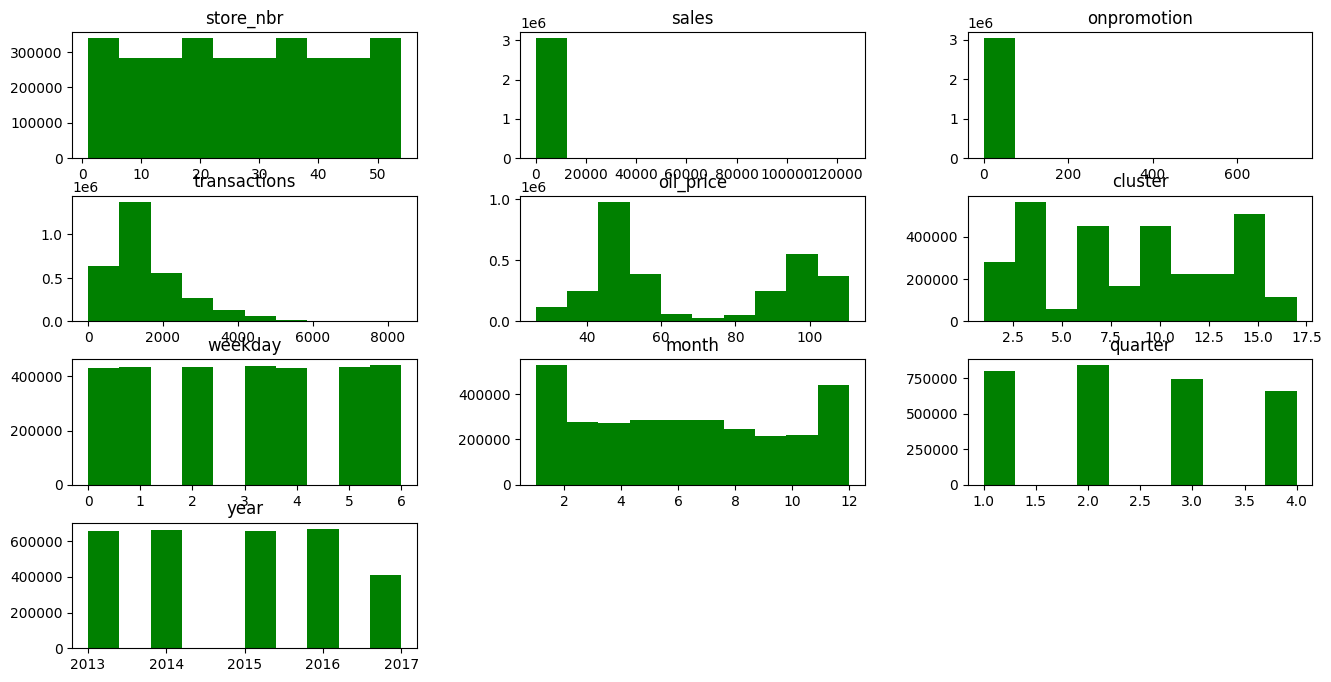

In [35]:
df4.hist(figsize=(16,8), grid=False, color = 'green')
plt.show

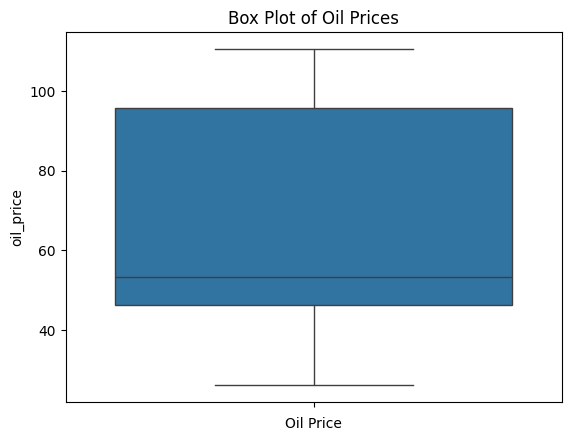

In [36]:
# Create the box plot of oil price to check outliers.
sns.boxplot(y=df4['oil_price'])

# Add title and labels
plt.title('Box Plot of Oil Prices')
plt.xlabel('Oil Price')

# Show the plot
plt.show()



<Axes: >

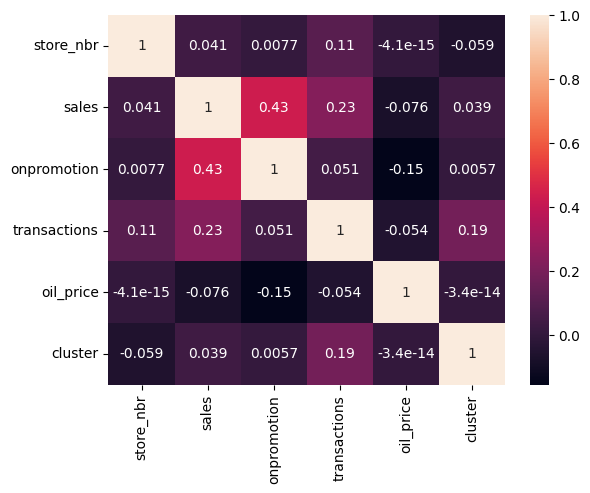

In [37]:
# Create a DataFrame of train_data with numerical columns only
train_data_num = df4.select_dtypes(include=['float64', 'int64'])

# Calculate the correlation matrix of the numerical columns
corr_matrix = train_data_num.corr()

# Visualizing the correlation matrix with a heatmap
sns.heatmap(corr_matrix, annot=True)

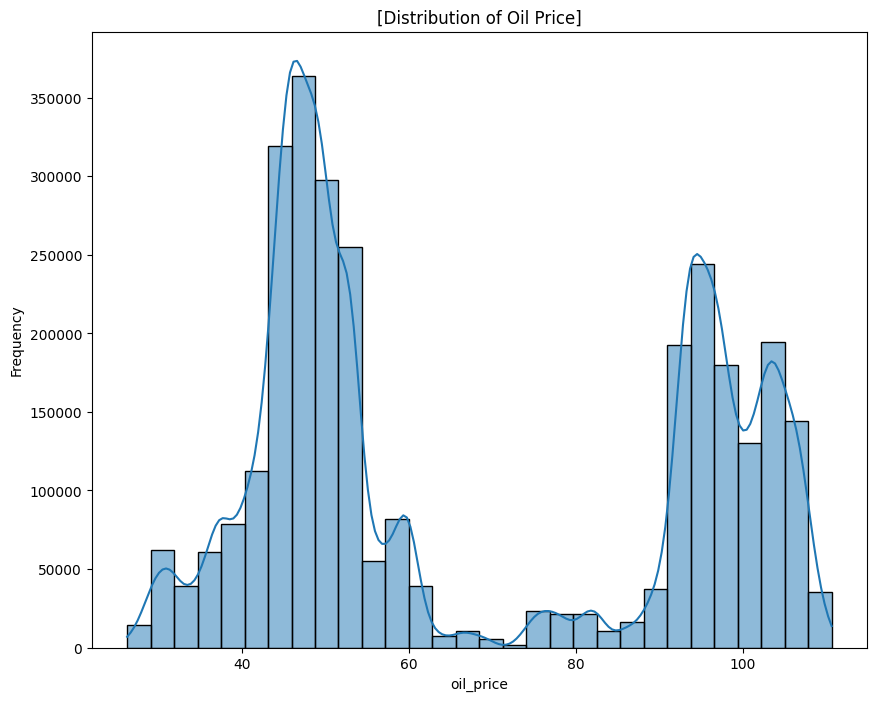

In [38]:
plt.figure(figsize=(10, 8))
sns.histplot(df4['oil_price'], bins=30, kde=True)
plt.title('[Distribution of Oil Price]')
plt.xlabel('oil_price')
plt.ylabel('Frequency')
plt.show()

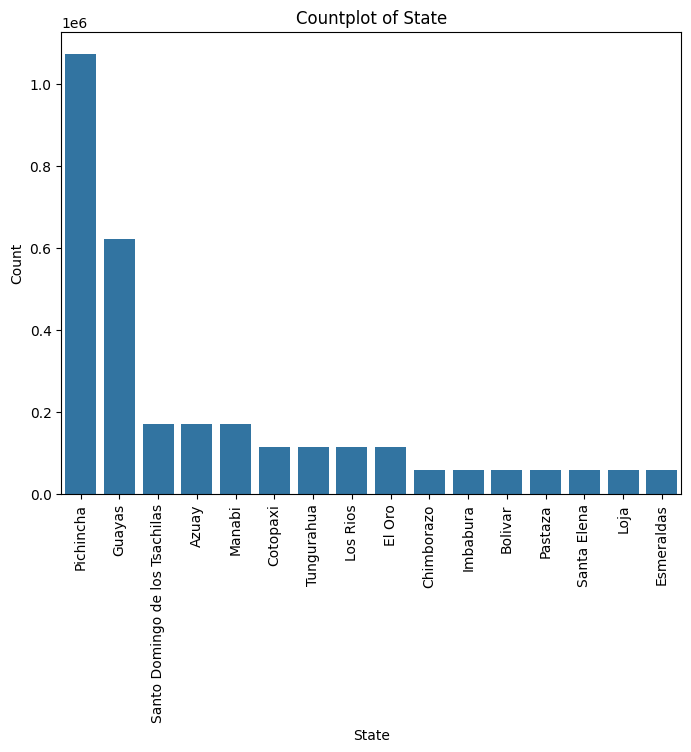

In [39]:

plt.figure(figsize=(8, 6))
sns.countplot(data=df4, x='state', order=df4['state'].value_counts().index)

plt.title('Countplot of State')
plt.xlabel('State')
plt.ylabel('Count')

plt.xticks(rotation=90) 
plt.show()




### Observations

The bar chart shows the distribution of stores across the top 5 cities with Quito: having the highest number of stores, with around 18 stores.

The box plot shows that the transactions fall within a certain range, around 800 to 1800, indicating a central trend. There are a few outliers, especially in the lower range, suggesting that there might be some transactions that are significantly higher or lower than the rest of the data.

The heatmap showing the correlation matrix provides th following insights:
There's a moderate positive correlation between sales and onpromotion with a figure of 0.43
There's a weak positive correlation between sales and transactions
The correlation between store_nbr and other variables is low
The correlation between oil_price and other variables is low

The histogram shows a bimodal distribution, meaning there are two distinct peaks in the frequency of oil prices. The two major peaks occur around the price range of 40-50 and 100-110.


#### **Hypothesis Test**

In [78]:

# Extract sales data before and after promotion
before_promotion = df4[df4['onpromotion'] == 0]['sales']
after_promotion = df4[df4['onpromotion'] == 1]['sales']

# Perform a t-test
t_stat, p_value = ttest_ind(before_promotion, after_promotion)

# Define the significance level
alpha = 0.05

# Print the results
print(f"T-statistic: {t_stat}")
print(f"P-value: {p_value}")

# Interpret the results
if p_value < alpha:
    print("The difference in sales before and after promotion is statistically significant.")
else:
    print("The difference in sales before and after promotion is not statistically significant.")


T-statistic: -197.15017507267746
P-value: 0.0
The difference in sales before and after promotion is statistically significant.


At a significance level of 5%, There is enough to conclude there's a change in sales after promotion

### **Analytical Questions**

In [41]:
#Is the train dataset complete (has all the required dates)?

df4['date'] = df4.index
# Get the minimum and maximum dates in the dataset
min_date = df4['date'].min()
max_date = df4['date'].max()

print(f"Date range in the dataset: {min_date} to {max_date}")

#Get a complete list of dates within the range 
complete_date_range= pd.date_range(start=min_date, end=max_date)

# Get the unique dates present in the dataset
present_dates = df4['date'].unique()

# Find missing dates by comparing the two lists
missing_dates = set(complete_date_range) - set(present_dates)

if not missing_dates:
    print("The train dataset is complete and contains all required dates.")
else:
    print("The train dataset is missing the following dates:")
    print(sorted(missing_dates))



Date range in the dataset: 2013-01-01 00:00:00 to 2017-08-15 00:00:00
The train dataset is missing the following dates:
[Timestamp('2013-12-25 00:00:00'), Timestamp('2014-12-25 00:00:00'), Timestamp('2015-12-25 00:00:00'), Timestamp('2016-12-25 00:00:00')]


The dataset is missing some dates as seen above

In [42]:
# Which dates have the lowest and highest sales for each year (excluding days the store was closed)?


grouped_data = df4.groupby('year')

# Find the dates with the highest and lowest sales for each year, excluding the dates with zero sales
years = []
max_dates = []
max_sales = []
min_dates = []
min_sales = []

for year, group in grouped_data:
    nonzero_sales_group = group[group['sales'] > 0]
    if not nonzero_sales_group.empty:
        max_sale_date = nonzero_sales_group['sales'].idxmax()
        min_sale_date = nonzero_sales_group['sales'].idxmin()
        max_sale_value = nonzero_sales_group['sales'].max()
        min_sale_value = nonzero_sales_group['sales'].min()

        years.append(year)
        max_dates.append(max_sale_date)
        max_sales.append(max_sale_value)
        min_dates.append(min_sale_date)
        min_sales.append(min_sale_value)

# Create the result DataFrame
result_data = {
    'Year': years,
    'Highest_Sales_Date': max_dates,
    'Highest_Sales': max_sales,
    'Lowest_Sales_Date': min_dates,
    'Lowest_Sales': min_sales
}
result_df = pd.DataFrame(result_data)
result_df

,Year,Highest_Sales_Date,Highest_Sales,Lowest_Sales_Date,Lowest_Sales
0,2013,2013-11-12,46271.000,2013-08-06,0.122
1,2014,2014-12-08,45361.000,2014-12-05,0.188
2,2015,2015-12-14,40351.460,2015-09-15,0.196
3,2016,2016-05-02,124717.000,2016-06-23,0.396
4,2017,2017-04-02,38422.625,2017-02-09,0.426


In [43]:
# Compare the sales for each month across the years and determine which month of which year had the highest sales.

result_df[result_df['Highest_Sales'] ==  result_df['Highest_Sales'].max()]

,Year,Highest_Sales_Date,Highest_Sales,Lowest_Sales_Date,Lowest_Sales
3,2016,2016-05-02,124717.0,2016-06-23,0.396


In [44]:
# Did the earthquake impact sales?


# Date of earthquake
earthquake_date = pd.Timestamp('2016-04-16')

# Split the data into before and after the earthquake
before = df4[df4['date'] < earthquake_date]
after = df4[df4['date'] >= earthquake_date]

# Compare sales before and after the earthquake
mean_sales_before = before['sales'].mean()
mean_sales_after = after['sales'].mean()

print(f"Mean sales before the earthquake: {mean_sales_before}")
print(f"Mean sales after the earthquake: {mean_sales_after}")

# Conduct a t-test to compare the means
t_stat, p_value = ttest_ind(before['sales'], after['sales'], equal_var=False)

print(f"T-statistic: {t_stat}")
print(f"P-value: {p_value}")


Mean sales before the earthquake: 314.7514160421047
Mean sales after the earthquake: 466.20427477007996
T-statistic: -96.03209079650537
P-value: 0.0


The mean sales increased from 314 to 466 and a T-stat of -96.03 indicates a very strong effect meaning the earthquake did impact sales



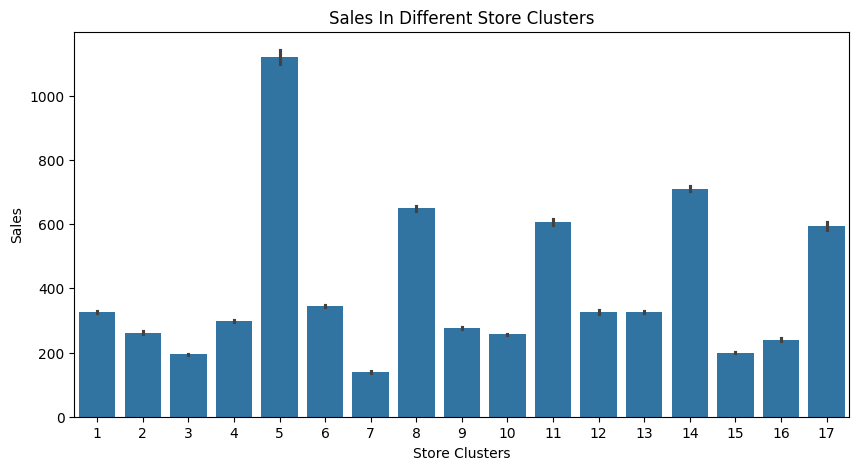

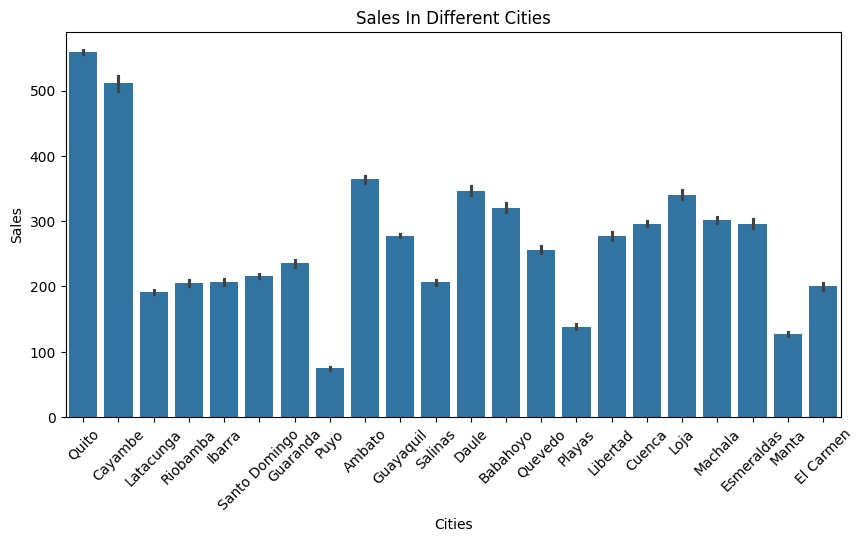

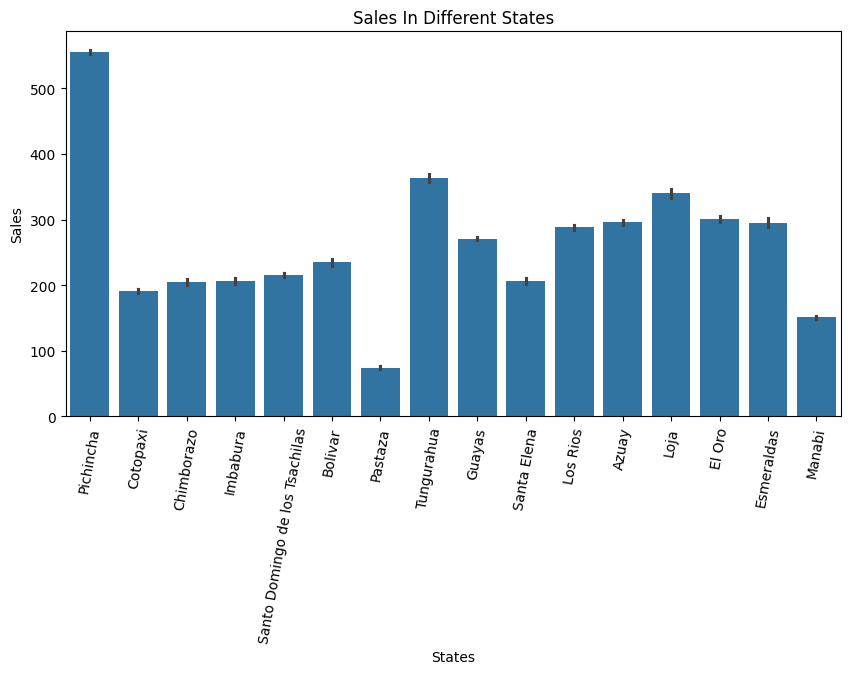

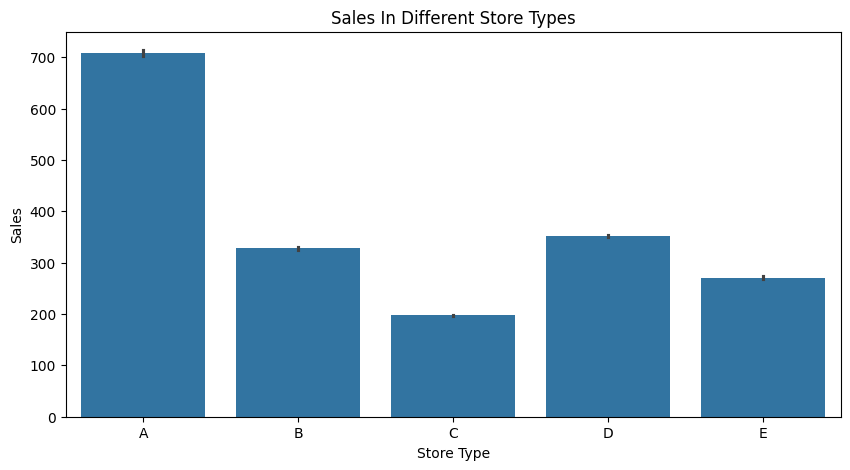

In [45]:
# Are certain stores or groups of stores selling more products? (Cluster, city, state, type)

# Compare the sales in the different store clusters

plt.figure(figsize=(10,5))
sns.barplot(x='cluster', y='sales', data=df4)
plt.title('Sales In Different Store Clusters')
plt.xlabel('Store Clusters')
plt.ylabel('Sales')
plt.show()

# Compare the sales in different cities

plt.figure(figsize=(10,5))
sns.barplot(x='city', y='sales', data=df4)
plt.title('Sales In Different Cities')
plt.xlabel('Cities')
plt.ylabel('Sales')
plt.xticks(rotation = 45)
plt.show()

# Compare the sales in different states

plt.figure(figsize=(10,5))
sns.barplot(x='state', y='sales', data=df4)
plt.title('Sales In Different States')
plt.xlabel('States')
plt.ylabel('Sales')
plt.xticks(rotation = 80)
plt.show()

# Compare the sales in different store types

store_types = ['A', 'B', 'C', 'D', 'E']

plt.figure(figsize=(10,5))
sns.barplot(x='store_type', y='sales', data=df4, order=store_types)
plt.title('Sales In Different Store Types')
plt.xlabel('Store Type')
plt.ylabel('Sales')
plt.show()

Text(0, 0.5, 'Sales')

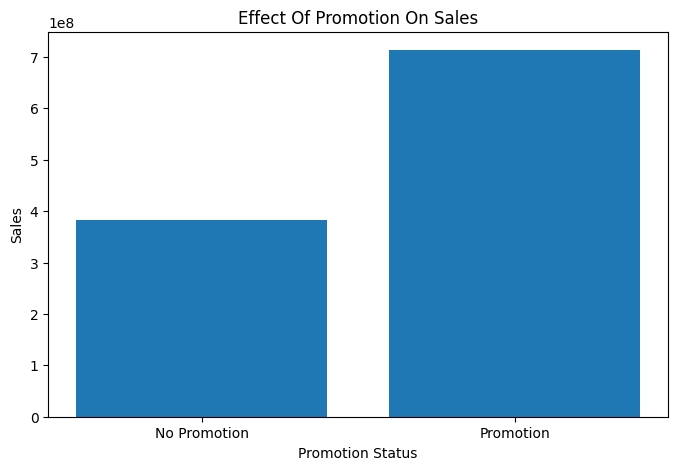

In [46]:
# Are sales affected by promotions, oil prices and holidays?

# Promotions Analysis
df4['promotion_status'] = df4['onpromotion'].apply(lambda x: 'No Promotion' if x == 0 else 'Promotion')

# Group by promotion and sum the sales
x = df4.groupby(['promotion_status'], as_index=False).agg({'sales':'sum'})

# Plot the sales of promotion and non_promotion families)
plt.figure(figsize=(8,5))
plt.bar(x.promotion_status, x.sales)
plt.title('Effect Of Promotion On Sales')
plt.xticks((0,1))
plt.xlabel('Promotion Status')
plt.ylabel('Sales')


In [47]:
# Oil Prices Analysis
df4['sales'].corr(df4['oil_price'])

-0.07567496710860729

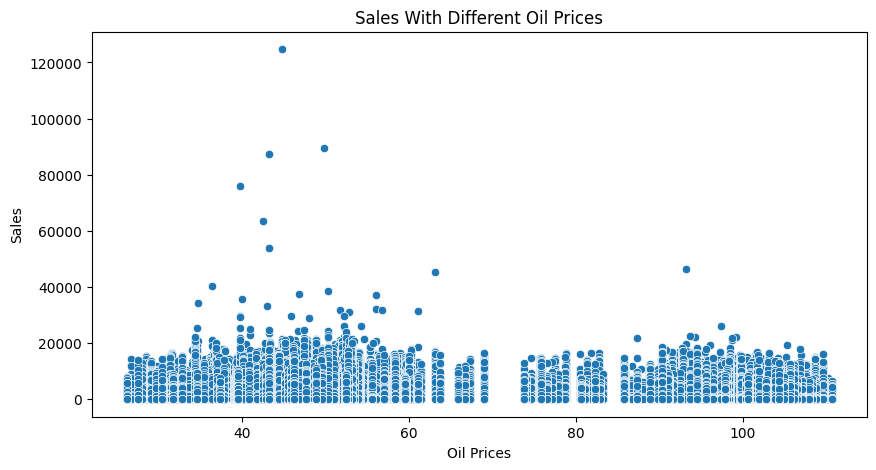

In [48]:
# Compare the sales with different oil prices

plt.figure(figsize=(10,5))
sns.scatterplot(x='oil_price', y='sales', data=df4)
plt.title('Sales With Different Oil Prices')
plt.xlabel('Oil Prices')
plt.ylabel('Sales')
plt.show()

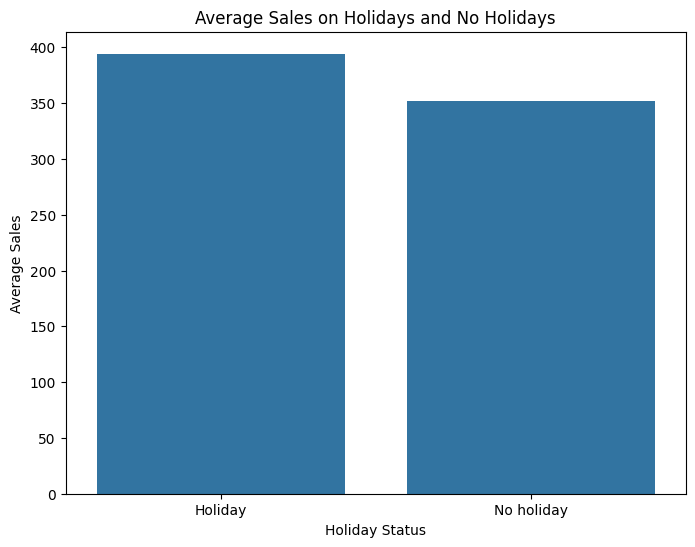

In [49]:
# Hoilday analysis
average_sales_by_holiday_status = df4.groupby('holiday_status')['sales'].mean().reset_index()

# Plot the average sales for holidays and no holidays
plt.figure(figsize=(8, 6))
sns.barplot(x='holiday_status', y='sales', data=average_sales_by_holiday_status)
plt.xlabel('Holiday Status')
plt.ylabel('Average Sales')
plt.title('Average Sales on Holidays and No Holidays')
plt.show()

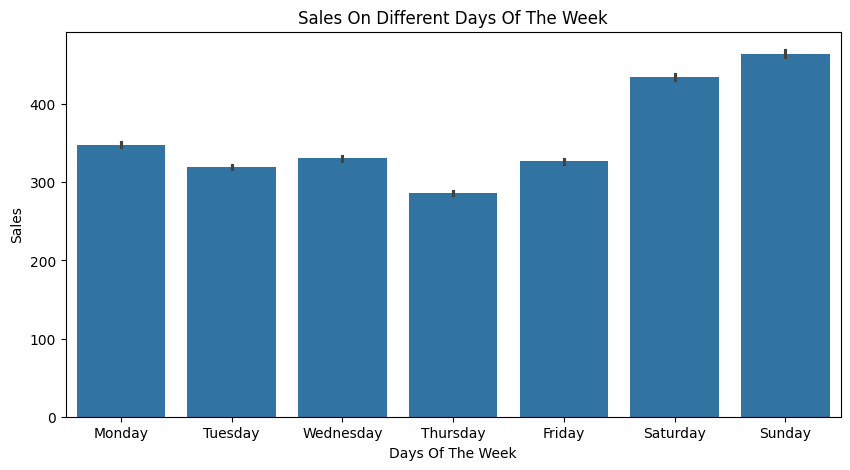

In [50]:
# From the date and its extractable features, the average sales on different days of the week can be analyzed

# Extract the year,month,day from the date.
df4['year'] = df4.date.dt.year
df4['month'] = df4.date.dt.month
df4['dayofmonth'] = df4.date.dt.day
df4['dayofweek'] = df4.date.dt.dayofweek
df4['dayname'] = df4.date.dt.strftime('%A')
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

plt.figure(figsize=(10,5))
sns.barplot(x='dayname', y='sales', data=df4, order=days)
plt.title('Sales On Different Days Of The Week')
plt.xlabel('Days Of The Week')
plt.ylabel('Sales')
plt.show()

Mean sales on payment days:  362.49489028142847
Mean sales on other days:  357.50074132058074
T-statistic for payment days vs other days:  1.957816869184039
P-value for payment days vs other days:  0.05025270384299515
Conclusion: Sales on payment days are not significantly different from sales on other days.
Mean sales on day before payment:  346.21901843751453
T-statistic for day before payment vs other days:  -4.583323543518636
P-value for day before payment vs other days:  4.57876484583293e-06
Conclusion: Sales on the day before payment are significantly different from sales on other days.
Mean sales on day after payment:  387.3632739661409
T-statistic for day after payment vs other days:  10.652695104016905
P-value for day after payment vs other days:  1.718691094105241e-26
Conclusion: Sales on the day after payment are significantly different from sales on other days.


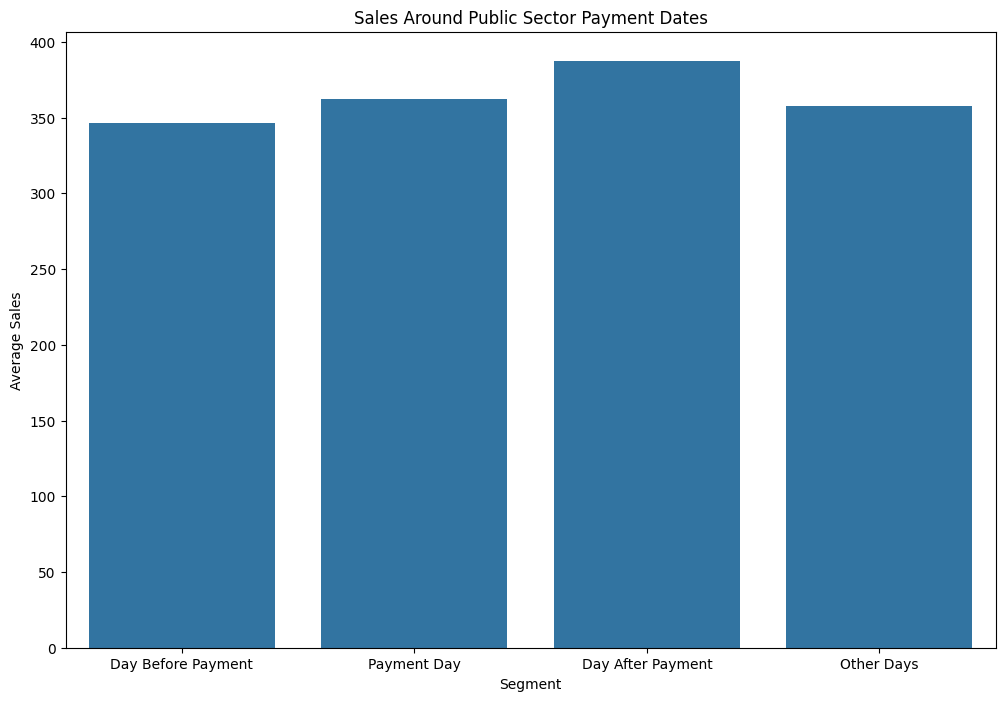

In [51]:
# Does the payment of wages in the public sector on the 15th and last days of the month influence the store sales?

# Identify the 15th and last day of each month
payment_dates = df4[(df4.index.day == 15) | (df4.index.is_month_end)].index

# Extract sales data for the day before, the day of, and the day after payment dates
day_before_payment = df4[df4.index.isin(payment_dates - pd.DateOffset(days=1))]['sales']
payment_day = df4[df4.index.isin(payment_dates)]['sales']
day_after_payment = df4[df4.index.isin(payment_dates + pd.DateOffset(days=1))]['sales']

# Extract sales data for other days
other_days = df4[~df4.index.isin(payment_dates) & 
                ~df4.index.isin(payment_dates - pd.DateOffset(days=1)) & 
                ~df4.index.isin(payment_dates + pd.DateOffset(days=1))]['sales']

# Perform t-tests to see if sales on payment days are significantly different from other days
t_stat_payment, p_value_payment = ttest_ind(payment_day, other_days, equal_var=False)
t_stat_before, p_value_before = ttest_ind(day_before_payment, other_days, equal_var=False)
t_stat_after, p_value_after = ttest_ind(day_after_payment, other_days, equal_var=False)

# Display the results
print("Mean sales on payment days: ", payment_day.mean())
print("Mean sales on other days: ", other_days.mean())
print("T-statistic for payment days vs other days: ", t_stat_payment)
print("P-value for payment days vs other days: ", p_value_payment)
if p_value_payment < 0.05:
    print("Conclusion: Sales on payment days are significantly different from sales on other days.")
else:
    print("Conclusion: Sales on payment days are not significantly different from sales on other days.")

print("Mean sales on day before payment: ", day_before_payment.mean())
print("T-statistic for day before payment vs other days: ", t_stat_before)
print("P-value for day before payment vs other days: ", p_value_before)
if p_value_before < 0.05:
    print("Conclusion: Sales on the day before payment are significantly different from sales on other days.")
else:
    print("Conclusion: Sales on the day before payment are not significantly different from sales on other days.")

print("Mean sales on day after payment: ", day_after_payment.mean())
print("T-statistic for day after payment vs other days: ", t_stat_after)
print("P-value for day after payment vs other days: ", p_value_after)
if p_value_after < 0.05:
    print("Conclusion: Sales on the day after payment are significantly different from sales on other days.")
else:
    print("Conclusion: Sales on the day after payment are not significantly different from sales on other days.")

# Visualization
segments = ['Day Before Payment', 'Payment Day', 'Day After Payment', 'Other Days']
means = [day_before_payment.mean(), payment_day.mean(), day_after_payment.mean(), other_days.mean()]

plt.figure(figsize=(12, 8))
sns.barplot(x=segments, y=means)
plt.title('Sales Around Public Sector Payment Dates')
plt.xlabel('Segment')
plt.ylabel('Average Sales')
plt.show()


From the graph, sales tend to be lower the day before payment days and higher the day after payment days. This could be likely to increased consumer spending after receiving wages.

### What is the difference between RMSLE, RMSE, MSE (or why is the MAE greater than all of them?)

MAE (Mean Absolute Error) measures the average absolute difference between predicted and actual values. 

MSE (Mean Squared Error) measures the average squared difference between predicted and actual values. It gives more weight to large errors.

RMSE (Root Mean Squared Error) is the square root of MSE and has the same sensitivity to outliers as MSE but is more interpretable.

RMSLE (Root Mean Squared Logarithmic Error) is useful when relative errors matter more than absolute errors.

MAE is generally greater than RMSE and MSE because it does not penalize larger errors as heavily as squared-error metrics.

## Data Modelling

In [52]:
df4.columns

Index(['store_nbr', 'family', 'sales', 'onpromotion', 'transactions',
       'holiday_type', 'locale', 'locale_name', 'description', 'transferred',
       'oil_price', 'city', 'state', 'store_type', 'cluster', 'holiday_status',
       'weekday', 'month', 'quarter', 'year', 'date', 'promotion_status',
       'dayofmonth', 'dayofweek', 'dayname'],
      dtype='object')

In [53]:
columns_to_drop = ['transactions','holiday_type', 'locale', 'locale_name', 'description', 'transferred',
       'oil_price', 'city', 'state', 'store_type', 'cluster', 'holiday_status',
       'weekday', 'month', 'quarter', 'date', 'promotion_status',
       'dayofmonth', 'dayofweek', 'dayname']
df4 = df4.drop(columns_to_drop, axis=1)

In [55]:
df4.head()

,store_nbr,family,sales,onpromotion,year
date,,,,,
2013-01-01,1,AUTOMOTIVE,0.0,0,2013
2013-01-01,1,BABY CARE,0.0,0,2013
2013-01-01,1,BEAUTY,0.0,0,2013
2013-01-01,1,BEVERAGES,0.0,0,2013
2013-01-01,1,BOOKS,0.0,0,2013


Splitting data into training and validation sets using the time-based split. This will be done based on the years.

In [56]:
# List the years in the dataset

df4['year'].unique()

array([2013, 2014, 2015, 2016, 2017])

In [60]:
# Establish the years for the training set and validation set
train_years = [2013, 2014, 2015, 2016]
val_year = [2017]

# Obtain the training set and validation set
train_set = df4.loc[(df4['year'].isin(train_years) & df4['year'].isin(train_years))]
val_set = df4.loc[(df4['year'].isin(val_year) & df4['year'].isin(val_year))]

# Print the shape of the training set and validation set
train_set.shape, val_set.shape

((2642706, 5), (411642, 5))

In [61]:
#Training set datatypes in columns
train_set.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2642706 entries, 2013-01-01 to 2016-12-31
Data columns (total 5 columns):
 #   Column       Dtype  
---  ------       -----  
 0   store_nbr    int64  
 1   family       object 
 2   sales        float64
 3   onpromotion  int64  
 4   year         int32  
dtypes: float64(1), int32(1), int64(2), object(1)
memory usage: 110.9+ MB


In [62]:
# Extract the original index column for later use
train_index = train_set.index
val_index = val_set.index

# Obtain the categorical columns to encode and numerical columns to scale
cat_columns_to_encode = ['family']
num_columns_to_scale = ['store_nbr', 'onpromotion', 'sales']

# Create separate DataFrames for categorical columns and numerical columns of training set
train_set_cat_df = train_set[cat_columns_to_encode]
train_set_num_df = train_set[num_columns_to_scale]

# Create separate DataFrames for categorical columns and numerical columns of validation set
val_set_cat_df = val_set[cat_columns_to_encode]
val_set_num_df = val_set[num_columns_to_scale]

## Feature Encoding

In [63]:
encoder = OneHotEncoder(sparse_output=False, drop='first')

In [64]:
# Use OneHotEncoder to encode the categorical columns of the training set
encoder.fit(train_set_cat_df)
train_set_cat_encoded = encoder.transform(train_set_cat_df).tolist()
train_set_cat_encoded_df = pd.DataFrame(train_set_cat_encoded, columns=encoder.get_feature_names_out(), index=train_index)

# View the encoded columns of the training set
train_set_cat_encoded_df.head()

,family_BABY CARE,family_BEAUTY,family_BEVERAGES,family_BOOKS,family_BREAD/BAKERY,family_CELEBRATION,family_CLEANING,family_DAIRY,family_DELI,family_EGGS,...,family_MAGAZINES,family_MEATS,family_PERSONAL CARE,family_PET SUPPLIES,family_PLAYERS AND ELECTRONICS,family_POULTRY,family_PREPARED FOODS,family_PRODUCE,family_SCHOOL AND OFFICE SUPPLIES,family_SEAFOOD
date,,,,,,,,,,,,,,,,,,,,,
2013-01-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2013-01-01,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2013-01-01,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2013-01-01,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2013-01-01,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [65]:
# Use OneHotEncoder to encode the categorical columns of the validation set
encoder.fit(val_set_cat_df)
val_set_cat_encoded = encoder.transform(val_set_cat_df).tolist()
val_set_cat_encoded_df = pd.DataFrame(val_set_cat_encoded, columns=encoder.get_feature_names_out(), index=val_index)

# View the encoded columns of the validation set
val_set_cat_encoded_df.head()

,family_BABY CARE,family_BEAUTY,family_BEVERAGES,family_BOOKS,family_BREAD/BAKERY,family_CELEBRATION,family_CLEANING,family_DAIRY,family_DELI,family_EGGS,...,family_MAGAZINES,family_MEATS,family_PERSONAL CARE,family_PET SUPPLIES,family_PLAYERS AND ELECTRONICS,family_POULTRY,family_PREPARED FOODS,family_PRODUCE,family_SCHOOL AND OFFICE SUPPLIES,family_SEAFOOD
date,,,,,,,,,,,,,,,,,,,,,
2017-01-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-01-01,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-01-01,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-01-01,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-01-01,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Feature Scaling

In [66]:
# Create a scaler object using MinMaxScaler

scaler = MinMaxScaler()

In [67]:
# Use MinMaxScaler to scale the numerical columns of the training set
scaler.fit(train_set_num_df)
train_set_num_scaled = scaler.transform(train_set_num_df).tolist()
train_set_num_scaled_df = pd.DataFrame(train_set_num_scaled, columns=scaler.get_feature_names_out(), index=train_index)


In [68]:
# Use MinMaxScaler to scale the numerical columns of the validation set
scaler.fit(val_set_num_df)
val_set_num_scaled = scaler.transform(val_set_num_df).tolist()
val_set_num_scaled_df = pd.DataFrame(val_set_num_scaled, columns=scaler.get_feature_names_out(), index=val_index)


In [69]:
# Combine the encoded and scaled DataFrames to get the final training and validation sets
train_final = pd.concat([train_set_cat_encoded_df, train_set_num_scaled_df], axis=1)
val_final = pd.concat([val_set_cat_encoded_df, val_set_num_scaled_df], axis=1)

# Print the shape of the final training and validation sets
train_final.shape, val_final.shape

((2642706, 35), (411642, 35))

In [70]:
# Separate the features (X) and the target variable (y) for training and validation sets
X_train = train_final.drop('sales', axis=1)
y_train = train_final['sales']
X_val = val_final.drop('sales', axis=1)
y_val = val_final['sales']

# Replace the elements of y_val with their absolute value in order to eliminate the presence of negative values in the y_val array
y_val = np.abs(y_val)
y_val = y_val.reset_index(drop=True)
y_val = y_val[y_val >= 0]

# Verify the lengths of the features(X) and the target variable (y) of the final training and validation sets
print("Length of X_train:", len(X_train))
print("Length of y_train:", len(y_train))
print("Length of X_test:", len(X_val))
print("Length of y_test:", len(y_val))

Length of X_train: 2642706
Length of y_train: 2642706
Length of X_test: 411642
Length of y_test: 411642


The following models will be used for training and later evaluated:

1. Linear Regression

2. XGBoost

3. AutoRegressive (AutoReg)


The evaluation metrics used to evaluate the performance of the models are:

Mean Absolute Error (MAE)
Mean Squared Error (MSE)
Root Mean Squared Error (RMSE)
Mean Squared Logarithmic Error (MSLE)
Root Mean Squared Logarithmic Error (RMSLE)
The primary evaluation metric for selecting the best performing model is the Root Mean Squared Logarithmic Error (RMSLE).

In [71]:
# Create an empty DataFrame to store the results of the evaluation metrics of each model

results = pd.DataFrame(columns=['Model', 'MAE', 'MSE', 'RMSE', 'MSLE', 'RMSLE'])
results

,Model,MAE,MSE,RMSE,MSLE,RMSLE


## Linear Regression Model

In [72]:
# Initialize the model
linear_regression_model = LinearRegression()

# Fit the model
linear_regression_model.fit(X_train, y_train)

# Make predictions on the final validation set
linear_regression_pred = linear_regression_model.predict(X_val)

# Calculate the evaluation metrics
linear_regression_mae = mean_absolute_error(y_val, linear_regression_pred)
linear_regression_mse = mean_squared_error(y_val, linear_regression_pred)
linear_regression_rmse = np.sqrt(linear_regression_mse)

# Define custom function to handle the negative predictions in order to calculate msle
def linear_regression_msle_with_non_negative_targets(y_val, linear_regression_pred):
    # Add a constant value to all target values to ensure they are non-negative
    y_val_non_negative = y_val + np.abs(np.min(y_val)) + 1
    
    # Add the same constant value to the predicted values
    linear_regression_pred_non_negative = linear_regression_pred + np.abs(np.min(y_val)) + 1
    
    # Calculate the MSLE using the transformed targets
    linear_regression_msle = mean_squared_log_error(y_val_non_negative, linear_regression_pred_non_negative)
    return linear_regression_msle

# Calculate msle using the custom function, then calculate rmsle
linear_regression_msle = linear_regression_msle_with_non_negative_targets(y_val, linear_regression_pred)
linear_regression_rmsle = np.sqrt(linear_regression_msle)

# Create a dictionary for the evaluation metrics of Linear Regression model
linear_regression_evaluation_metrics = pd.DataFrame({'Model': ['Linear Regression'], 'MAE': [linear_regression_mae],
                                                     'MSE': [linear_regression_mse], 'RMSE': [linear_regression_rmse],
                                                     'MSLE': [linear_regression_msle], 'RMSLE': [linear_regression_rmsle]})

# Add the linear regression evaluation metrics to the results DataFrame, then print the results DataFrame
results = pd.concat([results, linear_regression_evaluation_metrics], ignore_index=True)
results

,Model,MAE,MSE,RMSE,MSLE,RMSLE
0,Linear Regression,0.009328,0.000979,0.031287,0.000217,0.014727


The Linear Regression model appears to perform well given the low values of MAE, MSE, RMSE, MSLE, and RMSLE. These metrics suggest that the model's predictions are generally close to the actual values, and it handles both absolute and relative errors effectively.

## XGBoost Model

In [73]:
# Initialize the model
xgboost_model = XGBRegressor()

# Fit the model
xgboost_model.fit(X_train, y_train)

# Make predictions on the final validation set
xgboost_pred = xgboost_model.predict(X_val)

# Calculate the evaluation metrics
xgboost_mae = mean_absolute_error(y_val, xgboost_pred)
xgboost_mse = mean_squared_error(y_val, xgboost_pred)
xgboost_rmse = np.sqrt(xgboost_mse)

# Define custom function to handle the negative predictions in order to calculate msle
def xgboost_msle_with_non_negative_targets(y_val, xgboost_pred):
    # Add a constant value to all target values to ensure they are non-negative
    y_val_non_negative = y_val + np.abs(np.min(y_val)) + 1
    
    # Add the same constant value to the predicted values
    xgboost_pred_non_negative = xgboost_pred + np.abs(np.min(y_val)) + 1
    
    # Calculate the MSLE using the transformed targets
    xgboost_msle = mean_squared_log_error(y_val_non_negative, xgboost_pred_non_negative)
    return xgboost_msle

# Calculate msle using the custom function, then calculate rmsle
xgboost_msle = xgboost_msle_with_non_negative_targets(y_val, xgboost_pred)
xgboost_rmsle = np.sqrt(xgboost_msle)

# Create a dictionary for the evaluation metrics of xgboost model
xgboost_evaluation_metrics = pd.DataFrame({'Model': ['XGBoost'], 'MAE': [xgboost_mae], 'MSE': [xgboost_mse], 'RMSE': [xgboost_rmse],
                                           'MSLE': [xgboost_msle], 'RMSLE': [xgboost_rmsle]})

# Add the xgboost evaluation metrics to the results DataFrame, then print the results DataFrame
results = pd.concat([results, xgboost_evaluation_metrics], ignore_index=True)
results

,Model,MAE,MSE,RMSE,MSLE,RMSLE
0,Linear Regression,0.009328,0.000979,0.031287,0.000217,0.014727
1,XGBoost,0.008944,0.000784,0.028009,0.000173,0.013141


Based on the evaluation metrics, the XGBoost model performs better than the Linear Regression model across all metrics (MAE, MSE, RMSE, MSLE, and RMSLE). This suggests that XGBoost provides more accurate predictions, both in terms of absolute and relative errors.

## AutoReg Model

In [74]:
# Perform first-order differencing on y_train to ensure stationarity
y_train_diff = y_train.diff().dropna()

# Determine the best lag using Akaike Information Criterion (AIC)
max_lag = 10  # Define the maximum lag order to consider
best_aic = float('inf')  # Initialize best_aic to positive infinity
best_lag = 0  # Initialize best_lag to zero

for lag in range(1, max_lag + 1):
    aic_AR_model = AutoReg(y_train_diff, lags=lag)
    aic_AR_model_fit = aic_AR_model.fit()
    aic = -2 * aic_AR_model_fit.llf + 2 * (lag + 1)  # Calculate AIC manually
    if aic < best_aic:
        best_aic = aic
        best_lag = lag

# Initialize the model with the best lag
AR_model = AutoReg(y_train_diff, lags=best_lag)

# Fit the model
AR_model_fit = AR_model.fit()

# Make predictions
AR_start = len(y_train_diff)
AR_end = len(y_train_diff) + len(y_val) - 1
AR_pred_diff = AR_model_fit.predict(start=AR_start, end=AR_end)

# Reverse the differencing for predictions to be in the original scale
# We need the last value of y_train to revert the differenced predictions
last_train_value = y_train.iloc[-1]
AR_pred = last_train_value + AR_pred_diff.cumsum()

# Calculate evaluation metrics
AR_mae = mean_absolute_error(y_val, AR_pred)
AR_mse = mean_squared_error(y_val, AR_pred)
AR_rmse = np.sqrt(AR_mse)
AR_msle = mean_squared_log_error(y_val, AR_pred)
AR_rmsle = np.sqrt(AR_msle)

# Create a DataFrame for the evaluation metrics of the AR model
AR_evaluation_metrics = pd.DataFrame({
    'Model': ['AutoReg'], 
    'MAE': [AR_mae], 
    'MSE': [AR_mse], 
    'RMSE': [AR_rmse], 
    'MSLE': [AR_msle],
    'RMSLE': [AR_rmsle]
})

# Add the AR evaluation metrics to the results DataFrame, then print the results DataFrame
results = pd.concat([results, AR_evaluation_metrics], ignore_index=True)
results

,Model,MAE,MSE,RMSE,MSLE,RMSLE
0,Linear Regression,0.009328,0.000979,0.031287,0.000217,0.014727
1,XGBoost,0.008944,0.000784,0.028009,0.000173,0.013141
2,AutoReg,0.013528,0.001303,0.036100,0.001073,0.032762


The AutoReg model has the highest errors among the three models. As compared to the other two, it is the worst performing model

## Hyperparameter Tuning

In [ ]:
# Define the hyperparameter search space
param_distributions = {
    'learning_rate': [0.05, 0.1],
    'max_depth': [6, 7],
    'n_estimators': [1000, 1200]
}

# Define the scoring metric as negative RMSLE (to minimize it)
rmsle_scorer = make_scorer(mean_squared_log_error, greater_is_better=False)

# Initialize the XGBoost model
xgboost_model = XGBRegressor()

# Perform randomized search
random_search = RandomizedSearchCV(
    estimator=xgboost_model,
    param_distributions=param_distributions,
    n_iter=3,
    scoring=rmsle_scorer,
    random_state=42,
    cv=5
)

# Fit the randomized search on the entire training dataset
random_search.fit(X_train, y_train)

# Get the best model from the randomized search
best_model = random_search.best_estimator_

# Train the best model on the entire training dataset
best_model.fit(X_train, y_train)

Due to computer functionality ie.memory, I have been unable to tune my xgboost model. But due to it being the best amongst the three, it is the model that will be selected.

## Test Data Prediction

In [110]:
test= pd.read_csv(r"C:\Users\user\Documents\New folder\LP.3\OneDrive_1_7-16-2024\test.csv")
test.head()

,id,date,store_nbr,family,onpromotion
0,3000888,2017-08-16,1,AUTOMOTIVE,0
1,3000889,2017-08-16,1,BABY CARE,0
2,3000890,2017-08-16,1,BEAUTY,2
3,3000891,2017-08-16,1,BEVERAGES,20
4,3000892,2017-08-16,1,BOOKS,0


In [113]:
# Rename test to test_df to preserve the originality of test for later use
test_df = test

# Set the 'date' column of test_df as index
test_df = test_df.set_index('date')

# Extract the index column  of test_df for later use
test_index = test_df.index

# View the resulting test dataset
test_df.head()

,id,store_nbr,family,onpromotion
date,,,,
2017-08-16,3000888,1,AUTOMOTIVE,0
2017-08-16,3000889,1,BABY CARE,0
2017-08-16,3000890,1,BEAUTY,2
2017-08-16,3000891,1,BEVERAGES,20
2017-08-16,3000892,1,BOOKS,0


In [114]:
# Specify new numerical columns to scale as 'sales' column is absent in test dataset
test_num_columns_to_scale = ['store_nbr', 'onpromotion']

# Create seperate DataFrames for categorical columns and numerical columns of test_df
test_cat_df = test_df[cat_columns_to_encode]
test_num_df = test_df[test_num_columns_to_scale]

In [115]:
# Use OneHotEncoder to encode the categorical columns of test dataset
encoder.fit(test_cat_df)
test_cat_encoded = encoder.transform(test_cat_df).tolist()
test_cat_encoded_df = pd.DataFrame(test_cat_encoded, columns=encoder.get_feature_names_out(), index=test_index)

# View the encoded columns of test dataset
test_cat_encoded_df.head()

,family_BABY CARE,family_BEAUTY,family_BEVERAGES,family_BOOKS,family_BREAD/BAKERY,family_CELEBRATION,family_CLEANING,family_DAIRY,family_DELI,family_EGGS,...,family_MAGAZINES,family_MEATS,family_PERSONAL CARE,family_PET SUPPLIES,family_PLAYERS AND ELECTRONICS,family_POULTRY,family_PREPARED FOODS,family_PRODUCE,family_SCHOOL AND OFFICE SUPPLIES,family_SEAFOOD
date,,,,,,,,,,,,,,,,,,,,,
2017-08-16,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-08-16,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-08-16,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-08-16,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-08-16,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [116]:
# Use MinMaxScaler to scale the numerical columns of test dataset
scaler.fit(test_num_df)
test_num_scaled = scaler.transform(test_num_df).tolist()
test_num_scaled_df = pd.DataFrame(test_num_scaled, columns=scaler.get_feature_names_out(), index=test_index)

# View the scaled columns of test dataset
test_num_scaled_df.head()

,store_nbr,onpromotion
date,,
2017-08-16,0.0,0.000000
2017-08-16,0.0,0.000000
2017-08-16,0.0,0.003096
2017-08-16,0.0,0.030960
2017-08-16,0.0,0.000000


In [117]:
# Combine the encoded and scaled DataFrames to get the final test dataset
test_final = pd.concat([test_cat_encoded_df, test_num_scaled_df], axis=1)

# Print the shape of the final test dataset
test_final.shape

(28512, 34)

In [124]:
# Make predictions on the final test dataset using the best model
test_pred = xgboost_model.predict(test_final)
# Print the test predictions
print('Predictions:')
test_pred



Predictions:


array([-8.0852114e-05, -1.0138746e-04,  1.6363439e-04, ...,
        1.0405193e-02,  1.6676858e-03,  3.3127030e-04], dtype=float32)

In [125]:
 # Save the absolute values of sales predictions into test dataset as 'sales' column values
test['sales'] = np.abs(test_pred)

# Print the updated test dataset with absolute predictions
test

,id,store_nbr,family,onpromotion,sales
date,,,,,
2017-08-16,3000888,1,AUTOMOTIVE,0,0.000081
2017-08-16,3000889,1,BABY CARE,0,0.000101
2017-08-16,3000890,1,BEAUTY,2,0.000164
2017-08-16,3000891,1,BEVERAGES,20,0.016495
2017-08-16,3000892,1,BOOKS,0,0.000101
...,...,...,...,...,...
2017-08-31,3029395,9,POULTRY,1,0.003953
2017-08-31,3029396,9,PREPARED FOODS,0,0.000612
2017-08-31,3029397,9,PRODUCE,1,0.010405


In [126]:
# Create a dataset
new_df = test[['id', 'sales']]

# Display the first five rows of submission dataset
new_df.head()

,id,sales
date,,
2017-08-16,3000888,0.000081
2017-08-16,3000889,0.000101
2017-08-16,3000890,0.000164
2017-08-16,3000891,0.016495
2017-08-16,3000892,0.000101


## Model Persistence

In [131]:
# Create a dictionary to store all the Machine Learning components
model_components = {
    'model': xgboost_model,
    'encoder': encoder,
    'scaler': scaler
}

# Create an folder named 'end'
os.makedirs('export', exist_ok=True)

# Create a path to the folder
destination = os.path.join('.', 'export')

# Save the components to a file using pickle
with open (os.path.join(destination, 'ml_components.pkl'), 'wb') as f:
    pickle.dump(model_components, f)

# with all of its settings, feature names, and other necessary information.
xgboost_model.save_model(os.path.join(destination, 'xgboost_model'))


# Create a ZIP archive of the export folder
with zipfile.ZipFile('export.zip', 'w', zipfile.ZIP_DEFLATED) as zipf:
    for root, dirs, files in os.walk('export'):
        for file in files:
            zipf.write(os.path.join(root, file), os.path.relpath(os.path.join(root, file), 'export'))

## Conclusion

In conclusion, we determined Quito had the most sales, promotion on sales had an effect onsales, sales after the earthquake surged, holidays affected sales as well.
After creating and training models the xgboost model produced the best reults and as such was chosen.